In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1087.64it/s]


In [2]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_layers=4):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim, (num_layers-n)/num_layers) for n in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim, scale=1.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTCustom(embed_dim, scale)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size)).to(bool).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = x + self.attn(self.ln1(x), self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# https://arxiv.org/pdf/2105.14103.pdf
# I am not 100% sure this is correct but it seems to work :shrug:
# also, it seems to learn much faster than GPT but I am not sure why,
# maybe because it learns to separate positional attention from the rest?
# also, positions are approximated with 2 smaller matrices, and it seems that this is important
# (for some reason, 8 works much better than 32)
class AFTCustom(nn.Module):
    def __init__(self, embed_dim, scale=1.0):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.uv = nn.Parameter(torch.randn(2, block_size, 8) * 0.01 * scale, requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        
        with torch.no_grad():
            self.qkv.weight *= scale
            self.proj.weight *= scale
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        w = self.uv[0, :T] @ self.uv[1, :T].T # (T, T)
        w.masked_fill_(mask[:T, :T], float("-Inf"))

        exp_w = w.unsqueeze(0).exp() # (1, T, T)
        exp_k = k.clamp(max=20).exp() # (B, T, C)

        wkv = exp_w @ (exp_k * v) # (B, T, C)
        wk = exp_w @ exp_k # (B, T, C)
        Yt = F.sigmoid(q) * (wkv / wk)
        return self.proj(Yt)


class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long, device=self.device).unsqueeze(0)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 223 K 
-------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.895     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.32it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


And nowCOCOnOLW&L?xSTEnza&!?IgFbgtzMMfsUX'UueNuewO:3fsUpcbn&'&ECA:KZrqp
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 209/209 [00:08<00:00, 25.41it/s, loss=2.18, v_num=378]And nowss necain,
A sto shelt o fere sul swits;
Whe shor do a puplte, t
Epoch 1: 100%|██████████| 209/209 [00:07<00:00, 27.58it/s, loss=1.65, v_num=378, test_loss=2.170]And nows?
Whese is sprese the my resignor's that here bens.
And her lea
Epoch 2: 100%|██████████| 209/209 [00:07<00:00, 27.52it/s, loss=1.48, v_num=378, test_loss=1.780]And now her sleeping me,
Thou latest the lie to sight seizello wooss;
S
Epoch 3: 100%|██████████| 209/209 [00:07<00:00, 27.34it/s, loss=1.42, v_num=378, test_loss=1.600]And now but true to
my broudstine for thus sin as digzy, speech and dau
Epoch 4: 100%|██████████| 209/209 [00:07<00:00, 27.69it/s, loss=1.37, v_num=378, test_loss=1.550]And now this name soul divisisation one
For this nothing friends; they 
Epoch 5: 100%|██████████| 209/209 [00:07<00:00, 27.46it/s, loss=1.34, v_num=378, test_loss=1.500]And now as thy way, sweet would say 'Wise my weak?

Pray, no, good man;
Epo

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 209/209 [00:13<00:00, 15.58it/s, loss=1.15, v_num=378, test_loss=1.370]


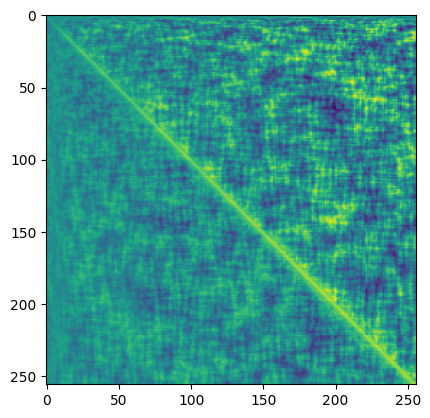

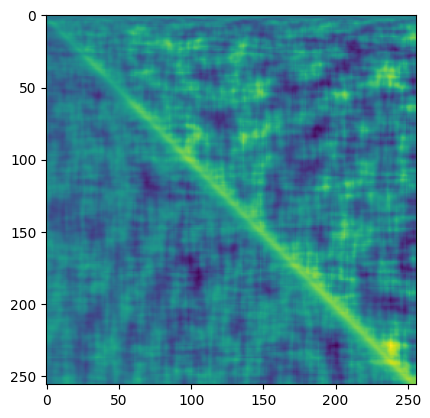

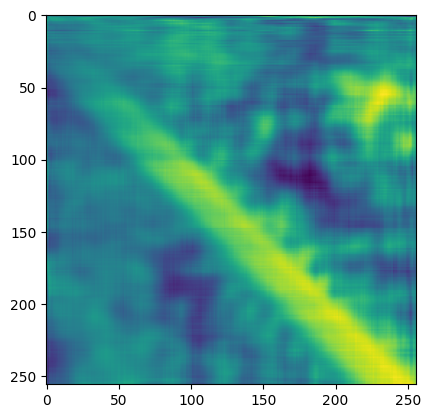

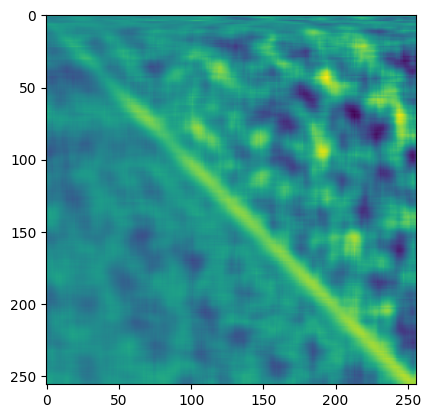

In [4]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow((b.attn.uv[0] @ b.attn.uv[1].T).detach().numpy())

In [5]:
print(model.generate("O God, O God!", 1024))

O God, O God!

FLORESCERS:
That horse! her is meeting to the seats makes
We asset marries, widwanting a living one.
I'll set down this merry of all guides,
Thou shalt livellia till subs age my containtness
Will thou drudge my will, how do the words
In office in this beauty's wave behind.

Shepherd:
Lieuted me; and so hear our heart with a fled.
A beggary of his pabasting him.

KING LEWIS XI:
He had done and done, and not so, but shall be
The ready tame of our face and doth magines:
Fellows to a prince to hour brother's dead;
And hear me bearing for his deceiing of teat
Of devotion but none of honour in his face:
My faith, I should not have moved my heart:
To my perform'd and that like the feat,
Or witness o' the trumpet of his head.

ROMEO:
What think'st thou, stiff stitle and seek,
As are that were stealty and longing thee
Are worst time of torment: barre him!

PAULINA:
Sin to them!

SICINIUS:
And I do pross, to my grew.

MERCY:
Hear me, and then, my lord,
Im thyself.

CORIOLANUS:
A g